# _*Pricing Bull Spreads*_ 

### Introduction
<br>
Suppose a <a href="http://www.theoptionsguide.com/bull-call-spread.aspx">bull spread</a> with strike prices $K_1 < K_2$ and an underlying asset whose spot price at maturity $S_T$ follows a given random distribution.
The corresponding payoff function is defined as:


$$\min\{\max\{S_T - K_1, 0\}, K_2 - K_1\}$$



In the following, a quantum algorithm based on amplitude estimation is used to estimate the expected payoff, i.e., the fair price before discounting, for the option:


$$\mathbb{E}\left[ \min\{\max\{S_T - K_1, 0\}, K_2 - K_1\} \right]$$


as well as the corresponding $\Delta$, i.e., the derivative of the option price with respect to the spot price, defined as:


$$
\Delta = \mathbb{P}\left[K_1 \leq S \leq K_2\right]
$$


The approximation of the objective function and a general introduction to option pricing and risk analysis on quantum computers are given in the following papers:

- <a href="https://arxiv.org/abs/1806.06893">Quantum Risk Analysis. Woerner, Egger. 2018.</a>
- <a href="https://arxiv.org/abs/1905.02666">Option Pricing using Quantum Computers. Stamatopoulos et al. 2019.</a>

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from qiskit import Aer
from qiskit.aqua.algorithms import IterativeAmplitudeEstimation
from qiskit.circuit.library import LogNormalDistribution, LinearAmplitudeFunction

### Uncertainty Model

We construct a circuit factory to load a log-normal random distribution into a quantum state.
The distribution is truncated to a given interval $[\text{low}, \text{high}]$ and discretized using $2^n$ grid points, where $n$ denotes the number of qubits used.
The unitary operator corresponding to the circuit factory implements the following: 

$$\big|0\rangle_{n} \mapsto \big|\psi\rangle_{n} = \sum_{i=0}^{2^n-1} \sqrt{p_i}\big|i\rangle_{n},$$

where $p_i$ denote the probabilities corresponding to the truncated and discretized distribution and where $i$ is mapped to the right interval using the affine map:

$$ \{0, \ldots, 2^n-1\} \ni i \mapsto \frac{\text{high} - \text{low}}{2^n - 1} * i + \text{low} \in [\text{low}, \text{high}].$$

In [2]:
# number of qubits to represent the uncertainty
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0 # initial spot price
vol = 0.4 # volatility of 40%
r = 0.05 # annual interest rate of 4%
T = 40 / 365 # 40 days to maturity

# resulting parameters for log-normal distribution
mu = ((r - 0.5 * vol**2) * T + np.log(S))
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2/2)
variance = (np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low  = np.maximum(0, mean - 3*stddev)
high = mean + 3*stddev

# construct circuit factory for uncertainty model
uncertainty_model = LogNormalDistribution(num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high))

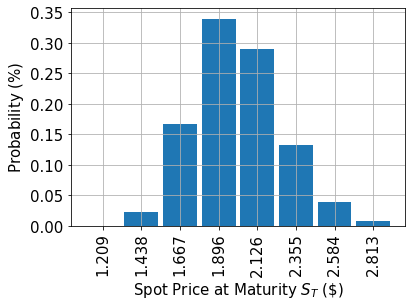

In [3]:
# plot probability distribution
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=0.2)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel('Spot Price at Maturity $S_T$ (\$)', size=15)
plt.ylabel('Probability ($\%$)', size=15)
plt.show()

### Payoff Function

The payoff function equals zero as long as the spot price at maturity $S_T$ is less than the strike price $K_1$, then increases linearly, and is bounded by $K_2$.
The implementation uses two comparators, that flip an ancilla qubit each from $\big|0\rangle$ to $\big|1\rangle$ if $S_T \geq K_1$ and $S_T \leq K_2$, and these ancillas are used to control the linear part of the payoff function.

The linear part itself is then approximated as follows.
We exploit the fact that $\sin^2(y + \pi/4) \approx y + 1/2$ for small $|y|$.
Thus, for a given approximation rescaling factor $c_\text{approx} \in [0, 1]$ and $x \in [0, 1]$ we consider

$$ \sin^2( \pi/2 * c_\text{approx} * ( x - 1/2 ) + \pi/4) \approx \pi/2 * c_\text{approx} * ( x - 1/2 ) + 1/2 $$

for small $c_\text{approx}$.

We can easily construct an operator that acts as

$$\big|x\rangle \big|0\rangle \mapsto \big|x\rangle \left( \cos(a*x+b) \big|0\rangle + \sin(a*x+b) \big|1\rangle \right),$$

using controlled Y-rotations.

Eventually, we are interested in the probability of measuring $\big|1\rangle$ in the last qubit, which corresponds to
$\sin^2(a*x+b)$.
Together with the approximation above, this allows to approximate the values of interest.
The smaller we choose $c_\text{approx}$, the better the approximation.
However, since we are then estimating a property scaled by $c_\text{approx}$, the number of evaluation qubits $m$ needs to be adjusted accordingly.

For more details on the approximation, we refer to:
<a href="https://arxiv.org/abs/1806.06893">Quantum Risk Analysis. Woerner, Egger. 2018.</a>

In [4]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price_1 = 1.438
strike_price_2 = 2.584

# set the approximation scaling for the payoff function
rescaling_factor = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price_1, strike_price_2]
slopes = [0, 1, 0]
offsets = [0, 0, strike_price_2 - strike_price_1]
f_min = 0
f_max = strike_price_2 - strike_price_1
bull_spread_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=rescaling_factor
)

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
bull_spread = bull_spread_objective.compose(uncertainty_model, front=True)

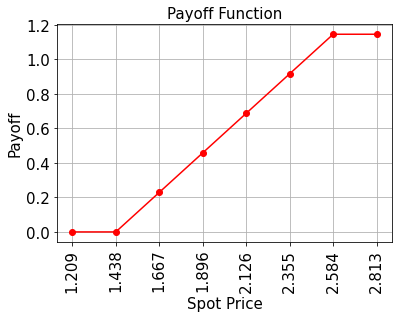

In [5]:
# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = uncertainty_model.values
y = np.minimum(np.maximum(0, x - strike_price_1), strike_price_2 - strike_price_1)
plt.plot(x, y, 'ro-')
plt.grid()
plt.title('Payoff Function', size=15)
plt.xlabel('Spot Price', size=15)
plt.ylabel('Payoff', size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [6]:
# evaluate exact expected value (normalized to the [0, 1] interval)
exact_value = np.dot(uncertainty_model.probabilities, y)
exact_delta = sum(uncertainty_model.probabilities[np.logical_and(x >= strike_price_1, x <= strike_price_2)])
print('exact expected value:\t%.4f' % exact_value)
print('exact delta value:   \t%.4f' % exact_delta)

exact expected value:	0.5695
exact delta value:   	0.9291


### Evaluate Expected Payoff

In [7]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

# construct amplitude estimation 
ae = IterativeAmplitudeEstimation(epsilon=epsilon, alpha=alpha, 
                                  state_preparation=bull_spread,
                                  objective_qubits=[num_uncertainty_qubits],
                                  post_processing=bull_spread_objective.post_processing)

In [8]:
result = ae.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=100)

In [9]:
conf_int = np.array(result['confidence_interval'])
print('Exact value:    \t%.4f' % exact_value)
print('Estimated value:\t%.4f' % result['estimation'])
print('Confidence interval: \t[%.4f, %.4f]' % tuple(conf_int))

Exact value:    	0.5695
Estimated value:	0.5694
Confidence interval: 	[0.5639, 0.5750]


### Evaluate Delta

The Delta is a bit simpler to evaluate than the expected payoff.
Similarly to the expected payoff, we use comparator circuits and ancilla qubits to identify the cases where $K_1 \leq S_T \leq K_2$.
However, since we are only interested in the probability of this condition being true, we can directly use an ancilla qubit as the objective qubit in amplitude estimation without any further approximation.

In [10]:
# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price_1, strike_price_2]
slopes = [0, 0, 0]
offsets = [0, 1, 0]
f_min = 0
f_max = 1

bull_spread_delta_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits, 
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints, 
)  # no approximation necessary, hence no rescaling factor

# construct the A operator by stacking the uncertainty model and payoff function together
bull_spread_delta = bull_spread_delta_objective.compose(uncertainty_model, front=True)

In [11]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

# construct amplitude estimation 
ae_delta = IterativeAmplitudeEstimation(epsilon=epsilon, alpha=alpha, 
                                        state_preparation=bull_spread_delta,
                                        objective_qubits=[num_uncertainty_qubits])

In [12]:
result_delta = ae_delta.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=100)

In [13]:
conf_int = np.array(result_delta['confidence_interval'])
print('Exact delta:    \t%.4f' % exact_delta)
print('Estimated value:\t%.4f' % result_delta['estimation'])
print('Confidence interval: \t[%.4f, %.4f]' % tuple(conf_int))

Exact delta:    	0.9291
Estimated value:	0.9290
Confidence interval: 	[0.9264, 0.9316]


In [14]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright